In [13]:
%load_ext autoreload

%autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [205]:
from getdata import YahooFinance
from getdata import SQLrepo
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
db_name = "stocks.sqlite"
connection=sqlite3.connect(database=db_name,check_same_thread=False)
repo=SQLrepo(connection)


In [206]:
repo.get_tabels_names()

[('Microsoft',), ('META',), ('Google',), ('Tesla',), ('Amazon',), ('Apple',), ('IBM',)]


In [207]:
df=repo.read_table(table_name="Google")

print(df.shape)
print(df.info())
df.head()

(4716, 1)
<class 'pandas.core.frame.DataFrame'>
Index: 4716 entries, 2004-08-19 00:00:00-04:00 to 2023-05-12 00:00:00-04:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   4716 non-null   float64
dtypes: float64(1)
memory usage: 73.7+ KB
None


,Close
Date,
2004-08-19 00:00:00-04:00,2.499133
2004-08-20 00:00:00-04:00,2.697639
2004-08-23 00:00:00-04:00,2.724787
2004-08-24 00:00:00-04:00,2.611960
2004-08-25 00:00:00-04:00,2.640104


In [201]:
y_google = wrangle_data(table_name="Google")

y_apple = wrangle_data(table_name="Apple")


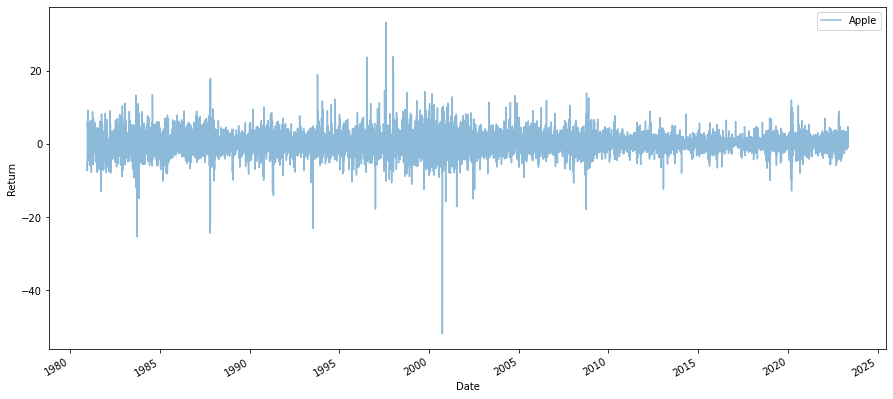

In [83]:
# conditional volatility
fig, ax = plt.subplots(figsize=(15, 7))
y_apple.plot(ax=ax ,label="Apple",alpha=0.5)
#y_google.plot(ax=ax ,label="Google", )

plt.xlabel("Date")
plt.ylabel("Return")
plt.legend();

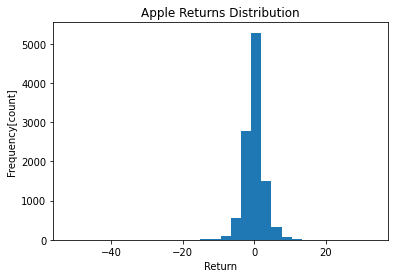

In [56]:
# unconditional volatility

plt.hist(y_apple, bins=30);
plt.xlabel("Return")
plt.ylabel("Frequency[count]")

plt.title("Apple Returns Distribution");

In [57]:
# Daily Volatility
apple_daily_volatility = y_apple.std()
google_daily_volatility = y_google.std()
print(f"Apple Daily Volatility: {apple_daily_volatility}")
print(f"Google Daily Volatility: {google_daily_volatility}")

Apple Daily Volatility: 2.819426456205723
Google Daily Volatility: 1.9445690670017297


In [58]:
# annual volatility
days=252
apple_annual_volatility = apple_daily_volatility * np.sqrt(days)
google_annual_volatility = google_daily_volatility * np.sqrt(days)
print(f"Apple Annual Volatility: {apple_annual_volatility}")
print(f"Google Annual Volatility: {google_annual_volatility}")

Apple Annual Volatility: 44.75700745773891
Google Annual Volatility: 30.869076950852847


In [59]:
y_apple.head()

Date
1980-12-15 00:00:00-05:00   -5.217055
1980-12-16 00:00:00-05:00   -7.339814
1980-12-17 00:00:00-05:00    2.475084
1980-12-18 00:00:00-05:00    2.899272
1980-12-19 00:00:00-05:00    6.102847
Name: Return, dtype: float64

In [89]:
# rolling volatility
apple_rolling_50d_volatility=y_apple.rolling(50).std().dropna()

google_rolling_50d_volatility=y_google.rolling(50).std().dropna()

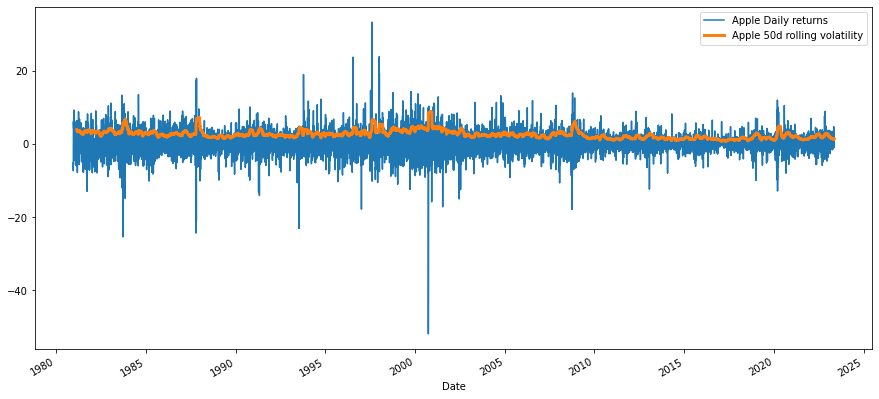

In [64]:
# conditional volatility
fig, ax = plt.subplots(figsize=(15, 7))
y_apple.plot(ax=ax ,label="Apple Daily returns")

apple_rolling_50d_volatility.plot(ax=ax ,label="Apple 50d rolling volatility",linewidth=3)

plt.xlabel("Date")

plt.legend();

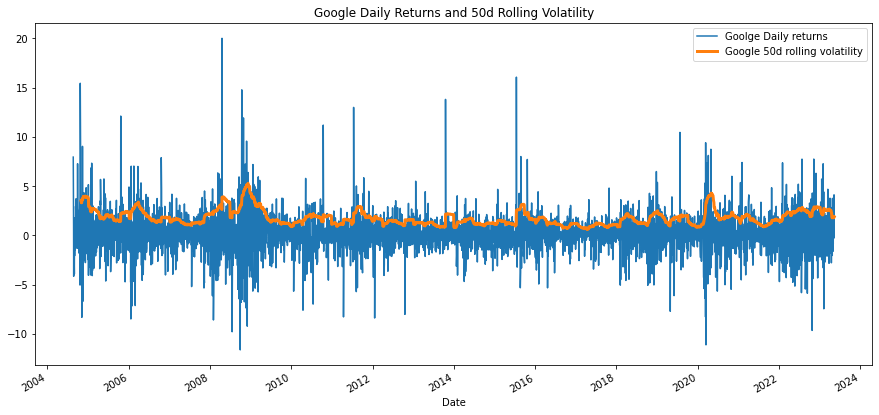

In [93]:
# conditional volatility for google stock
fig, ax = plt.subplots(figsize=(15, 7))
y_google.plot(ax=ax ,label="Goolge Daily returns")

google_rolling_50d_volatility.plot(ax=ax ,label="Google 50d rolling volatility",linewidth=3)

plt.title("Google Daily Returns and 50d Rolling Volatility")

plt.xlabel("Date")

plt.legend();

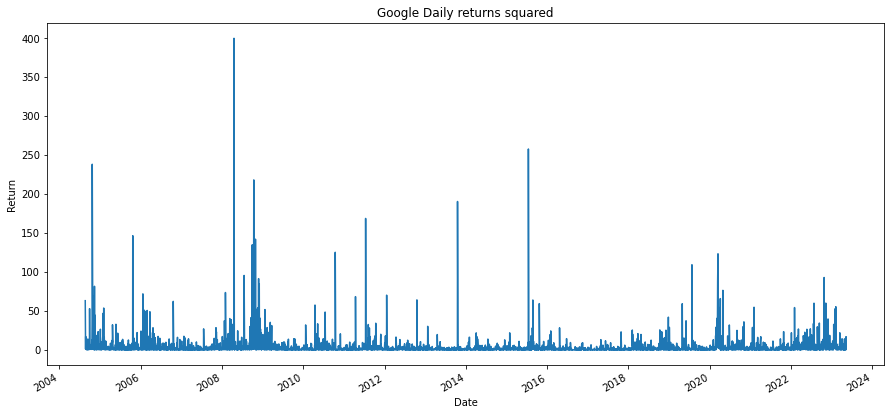

In [92]:
# squared returns
fig, ax = plt.subplots(figsize=(15, 7))
(y_google**2).plot(ax=ax ,title="Google Daily returns squared")

plt.xlabel("Date")
plt.ylabel("Return");

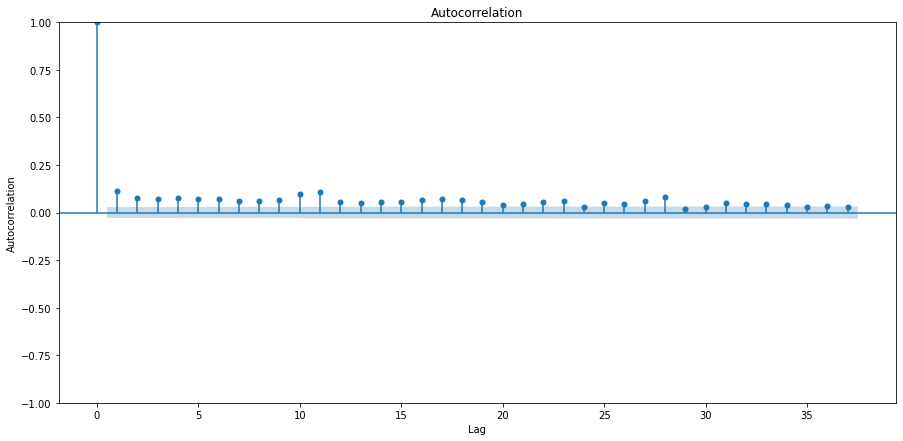

In [85]:
fig, ax = plt.subplots(figsize=(15, 7))

plot_acf(y_google**2, ax=ax, )
plt.xlabel("Lag")
plt.ylabel("Autocorrelation");


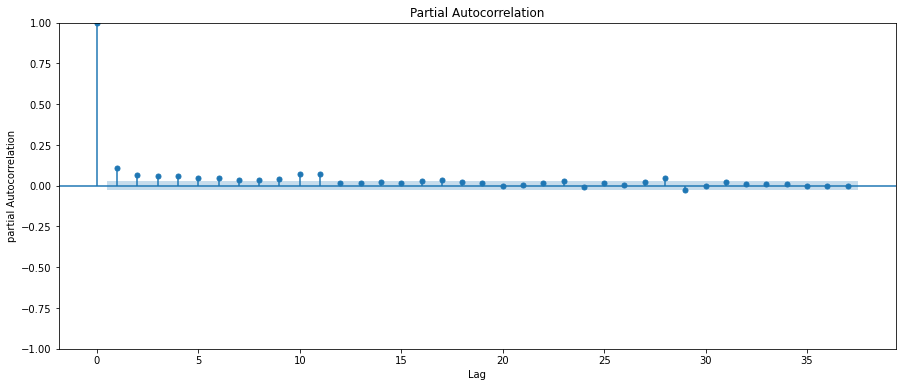

In [202]:
fig, ax = plt.subplots(figsize=(15, 6))

plot_pacf(y_google**2, ax=ax, method='ywm')
plt.xlabel("Lag")
plt.ylabel("partial Autocorrelation");

#lag 7 is significant

In [324]:
import yfinance as yf 
import pandas as pd
df=yf.Ticker("AAPL")
df = df.history(period="max")

df.head()


df['Return']=df['Close'].pct_change()*100

y=df['Return'].dropna()

y = y.resample('B').interpolate(method='linear')

In [325]:
cut=int(len(y) * 0.80)
y_train= y.iloc[:cut]
y_test = y.iloc[cut:]

y_train.tail(), y_test.head()

(Date
 2014-11-12 00:00:00-05:00    1.412985
 2014-11-13 00:00:00-05:00    1.411231
 2014-11-14 00:00:00-05:00    1.205468
 2014-11-17 00:00:00-05:00   -0.166390
 2014-11-18 00:00:00-05:00    1.298352
 Freq: B, Name: Return, dtype: float64,
 Date
 2014-11-19 00:00:00-05:00   -0.692828
 2014-11-20 00:00:00-05:00    1.430194
 2014-11-21 00:00:00-05:00    0.137537
 2014-11-24 00:00:00-05:00    1.854577
 2014-11-25 00:00:00-05:00   -0.868257
 Freq: B, Name: Return, dtype: float64)

In [326]:
model=AutoReg(y_train,lags=6).fit()
model.forecast()

2014-11-19 00:00:00-05:00    0.199655
Freq: B, dtype: float64

In [422]:
def wrangle_data(table_name):
    """Get and Wrangle the data from the db and add the pct to it
    Args:
      table_name str
      >>> wrangle_data(table_name="Google")
    """

    df=repo.read_table(table_name=table_name)
    
    df['Returns']= df.pct_change()
    df=df.dropna()
    
    df.index = pd.to_datetime(df.index,utc=True)
    #df=df.resample('d').ffill().tz_convert(y.index[0].tz)
    df = df.reindex(pd.date_range(start=df.index[0], end=df.index[-1], freq='D')).ffill()
    
    
    
    
    

    return df['Returns']

In [437]:
y= repo.read_table(table_name="Google")
y.index=pd.to_datetime(y.index,utc=True)
y.loc['2014-12-08':'2014-12-17']

,Close
Date,
2014-12-08 05:00:00+00:00,26.276857
2014-12-09 05:00:00+00:00,26.595482
2014-12-10 05:00:00+00:00,26.230984
2014-12-11 05:00:00+00:00,26.344671
2014-12-12 05:00:00+00:00,25.861996
2014-12-15 05:00:00+00:00,25.619661
2014-12-16 05:00:00+00:00,24.701681
2014-12-17 05:00:00+00:00,25.175381


In [425]:
y= wrangle_data(table_name="Google")

cut=int(len(y_google) * 0.80)
y_train= y.iloc[:cut]
y_test = y.iloc[cut:]

In [428]:
y_train.tail(10), y_test.head(10)

(2014-12-08 04:00:00+00:00    0.015936
 2014-12-09 04:00:00+00:00    0.015936
 2014-12-10 04:00:00+00:00    0.015936
 2014-12-11 04:00:00+00:00    0.015936
 2014-12-12 04:00:00+00:00    0.015936
 2014-12-13 04:00:00+00:00    0.015936
 2014-12-14 04:00:00+00:00    0.015936
 2014-12-15 04:00:00+00:00    0.015936
 2014-12-16 04:00:00+00:00    0.015936
 2014-12-17 04:00:00+00:00    0.015936
 Freq: D, Name: Returns, dtype: float64,
 2014-12-18 04:00:00+00:00    0.015936
 2014-12-19 04:00:00+00:00    0.015936
 2014-12-20 04:00:00+00:00    0.015936
 2014-12-21 04:00:00+00:00    0.015936
 2014-12-22 04:00:00+00:00    0.015936
 2014-12-23 04:00:00+00:00    0.015936
 2014-12-24 04:00:00+00:00    0.015936
 2014-12-25 04:00:00+00:00    0.015936
 2014-12-26 04:00:00+00:00    0.015936
 2014-12-27 04:00:00+00:00    0.015936
 Freq: D, Name: Returns, dtype: float64)

In [277]:
model=AutoReg(y_train,lags=6).fit()

c:\Users\Desco\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [280]:
model.forecast()

c:\Users\Desco\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Desco\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


KeyError: 0

In [216]:
y_train.loc["2014-12-10":"2014-12-20"]

Date
2014-12-10   -1.370527
2014-12-11    0.433409
2014-12-12   -1.832156
2014-12-15   -0.937029
2014-12-16   -3.583108
2014-12-17    1.917682
2014-12-18    1.229973
2014-12-19    1.027198
Freq: D, Name: Return, dtype: float64

In [220]:
Return=y_train
# Check index


# Check index
print(Return.index)

# Check for missing dates
expected_index = pd.date_range(start=Return.index.min(), end=Return.index.max(), freq='D')
missing_dates = expected_index[~expected_index.isin(Return.index)]
print("Missing dates:", missing_dates)

# Compare data values with index
for date, value in Return.items():
    if date != Return.index[Return.index.get_loc(date)]:
        print("Mismatched date:", date)

# Reindex with missing dates (if necessary)
Return = Return.reindex(expected_index)

# Check the updated index and missing dates again
print(Return.index)
missing_dates = expected_index[~expected_index.isin(Return.index)]
print("Missing dates after reindexing:", missing_dates)

DatetimeIndex(['2004-08-20', '2004-08-23', '2004-08-24', '2004-08-25',
               '2004-08-26', '2004-08-27', '2004-08-30', '2004-08-31',
               '2004-09-01', '2004-09-02',
               ...
               '2019-08-01', '2019-08-02', '2019-08-05', '2019-08-06',
               '2019-08-07', '2019-08-08', '2019-08-09', '2019-08-12',
               '2019-08-13', '2019-08-14'],
              dtype='datetime64[ns]', name='Date', length=3772, freq=None)
Missing dates: DatetimeIndex(['2004-08-21', '2004-08-22', '2004-08-28', '2004-08-29',
               '2004-09-04', '2004-09-05', '2004-09-06', '2004-09-11',
               '2004-09-12', '2004-09-18',
               ...
               '2019-07-13', '2019-07-14', '2019-07-20', '2019-07-21',
               '2019-07-27', '2019-07-28', '2019-08-03', '2019-08-04',
               '2019-08-10', '2019-08-11'],
              dtype='datetime64[ns]', length=1701, freq=None)
DatetimeIndex(['2004-08-20', '2004-08-21', '2004-08-22', '2004-08-23